In [1]:
# Import Packages
from collections import Counter
import cv2
import glob
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import random 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import scikitplot as skplt
from scipy import interp
from sklearn.preprocessing import label_binarize
import tensorflow as tf
import torch
from torch import nn, optim 
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torchviz import make_dot, make_dot_from_trace

# Import Scripts
from prepare_dataset import FaceDataSet
from facelayers import FaceModule, FaceModule2, FaceModule3, FaceModule4

In [2]:
CUDA = torch.cuda.is_available()

def seed_everything(seed=1234):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(7)

face_files = glob.glob('yalefaces/*.*')

In [3]:
# FaceCascade code was borrowed from this site:
# http://hanzratech.in/2015/02/03/face-recognition-using-opencv.html
cascadePath = r"/anaconda3/lib/python3.7/site-packages/cv2/data/haarcascade_frontalface_default.xml"
faceCascade = cv2.CascadeClassifier(cascadePath)

# Function for reading in images was borrowed from this site: 
# fhttps://github.com/yadavabhishekkumar/face-recognition-training-testing/blob/master/trainyale.py

def get_images_and_labels(image_paths):
    # Append all the absolute image paths in a list image_paths
    # We will not read the image with the .sad extension in the training set
    # Rather, we will use them to test our accuracy of the training
    #     image_paths = [os.path.join(path, f) for f in os.listdir(path) if not f.endswith('.sad')]
    # images will contains face images
    images = []
    # labels will contains the label that is assigned to the image
    labels = []
    for image_path in image_paths:
        # Read the image and convert to grayscale
        image_pil = Image.open(image_path).convert('L')
        # Convert the image format into numpy array
        image = np.array(image_pil, 'uint8')
        # Get the label of the image
        nbr = os.path.split(image_path)[1].split(".")[1] #.replace("subject", "")
        # Detect the face in the image
        faces = faceCascade.detectMultiScale(image)
        # If face is detected, append the face to images and the label to labels
        for (x, y, w, h) in faces:
            timage = cv2.resize(image[y: y + h, x: x + w], (128, 128)).reshape((1,128,128))
            images.append(timage/255.0)
            labels.append(nbr)
    # return the images list and labels list
    return images, labels

fac_exp = ['glasses', 'happy', 'leftlight', 'normal', 'rightlight', 'sad', 'sleepy', 'surprised', 'wink', 'centerlight','noglasses']
images, labels = get_images_and_labels(face_files)

#Conver the labels to indexes (a numeric value)
labels = [fac_exp.index(label)  for label in labels]

In [4]:
#Splitting train test set
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=.2)

#Creating the pytorch train and test loader 
train_loader = torch.utils.data.DataLoader(FaceDataSet(X_train, y_train), batch_size=16)
test_loader = torch.utils.data.DataLoader(FaceDataSet(X_test, y_test), len(X_test), shuffle=False)

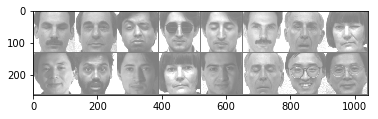

sleepy noglasses  wink glasses sleepy centerlight surprised  wink


In [5]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
plt.show()

print(' '.join('%5s' % fac_exp[labels[j]] for j in range(8)))

In [6]:
class Logger(object):
    
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def image_summary(self, tag, images, step):
        """Log a list of images."""

        img_summaries = []
        for i, img in enumerate(images):
            # Write the image to a string
            try:
                s = StringIO()
            except:
                s = BytesIO()
            scipy.misc.toimage(img).save(s, format="png")

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            img_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, i), image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=img_summaries)
        self.writer.add_summary(summary, step)
        
    def histo_summary(self, tag, values, step, bins=1000):
        """Log a histogram of the tensor of values."""

        # Create a histogram using numpy
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill the fields of the histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()

In [7]:
# The 4 Networks with different number of layers each defined in facelayers.py
# net = FaceModule()
# net = FaceModule2()
# net = FaceModule3()
net = FaceModule4()

if CUDA:
    net = net.cuda()

# Definind the criterion and the optimizer
logger = Logger('./logs')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [8]:
# 10 epoch for comparing the 4 networks
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        
        if CUDA:
            inputs = Variable(inputs.cuda())
            labels = Variable(labels.cuda())

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 5 == 4:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 50))
            running_loss = 0.0

print('Finished Training')

/Users/dariusbailey/Documents/GWU/DATS6401/Yale_Faces_Completed/facelayers.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.log_softmax(self.fully_connected2(x))


[1,     5] loss: 0.323
[2,     5] loss: 0.071
[3,     5] loss: 0.049
[4,     5] loss: 0.026
[5,     5] loss: 0.013
[6,     5] loss: 0.007
[7,     5] loss: 0.005
[8,     5] loss: 0.004
[9,     5] loss: 0.003
[10,     5] loss: 0.002
Finished Training


Now Evaluating
Accuracy = 57%


/Users/dariusbailey/Documents/GWU/DATS6401/Yale_Faces_Completed/facelayers.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.log_softmax(self.fully_connected2(x))


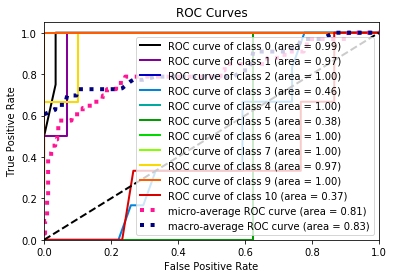

In [9]:
print('Now Evaluating')
net.eval()
test_inputs, labels = next(iter(test_loader))
if CUDA:
    test_inputs = test_inputs.cuda()
    labels = labels.cuda()
output = net(test_inputs)
pred = output.data.max(1, keepdim=True)[1]
correct = pred.eq(labels.data.view_as(pred)).cpu().sum()
print("Accuracy = {}%".format(100. * correct / len(test_loader.dataset)))

y_pred = pred.cpu().numpy().flatten()
y_actual = labels.cpu().numpy().reshape((33,1))

y_probs = torch.nn.functional.softmax(output, dim=1)

## Plot ROC AUC Curve
skplt.metrics.plot_roc(y_actual, y_probs.cpu().detach().numpy())
plt.show()

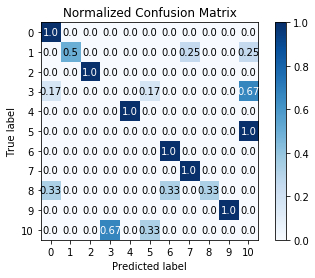

In [10]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

In [11]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())
    
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.conv1.weight 	 torch.Size([16, 1, 3, 3])
conv1.conv1.bias 	 torch.Size([16])
batchnorm1.weight 	 torch.Size([16])
batchnorm1.bias 	 torch.Size([16])
batchnorm1.running_mean 	 torch.Size([16])
batchnorm1.running_var 	 torch.Size([16])
batchnorm1.num_batches_tracked 	 torch.Size([])
conv2.conv1.weight 	 torch.Size([32, 16, 3, 3])
conv2.conv1.bias 	 torch.Size([32])
batchnorm2.weight 	 torch.Size([32])
batchnorm2.bias 	 torch.Size([32])
batchnorm2.running_mean 	 torch.Size([32])
batchnorm2.running_var 	 torch.Size([32])
batchnorm2.num_batches_tracked 	 torch.Size([])
conv3.conv1.weight 	 torch.Size([64, 32, 3, 3])
conv3.conv1.bias 	 torch.Size([64])
batchnorm3.weight 	 torch.Size([64])
batchnorm3.bias 	 torch.Size([64])
batchnorm3.running_mean 	 torch.Size([64])
batchnorm3.running_var 	 torch.Size([64])
batchnorm3.num_batches_tracked 	 torch.Size([])
fully_connected1.weight 	 torch.Size([1024, 12544])
fully_connected1.bias 	 torch.Size([1024])
batchnorm4.weight 	

/Users/dariusbailey/Documents/GWU/DATS6401/Yale_Faces_Completed/facelayers.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.log_softmax(self.fully_connected2(x))


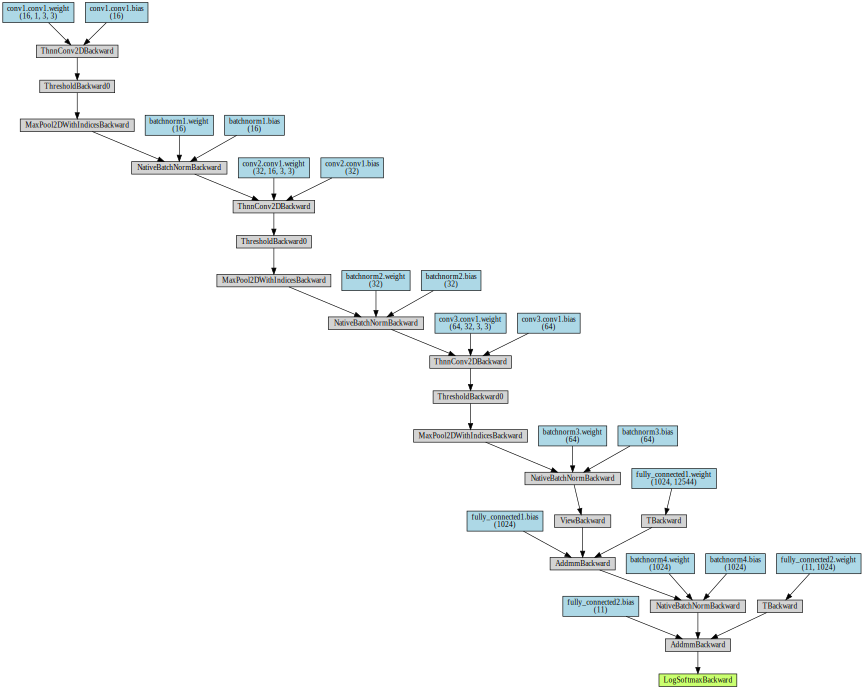

In [12]:
# Save the chosen model's learned parameters so that we can use it later for ColorFERET
torch.save(net.state_dict(), 'model4.pkl')

# Visualize the netwrok
make_dot(net(images), params=dict(net.named_parameters()))

/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 432x288 with 0 Axes>

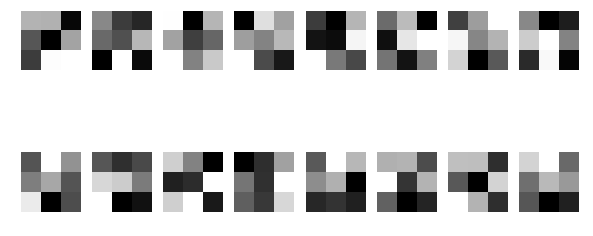

In [13]:
# Code borrowed from: https://github.com/Airconaaron/blog_post_visualizing_pytorch_cnn/blob/master/Visualizing%20Learned%20Filters%20in%20PyTorch.ipynb
# Using matplotlib to print out each individual filter and layers as if they were python objects
model_weights = torch.load("model4.pkl", map_location={'cuda:0': 'cpu', 'cuda:1' : 'cpu'})

fig = plt.figure()
plt.figure(figsize=(10,10))
for idx, filt  in enumerate(model_weights['conv1.conv1.weight']):
    #print(filt[0, :, :])
    plt.subplot(4,8, idx + 1)
    plt.imshow(filt[0, :, :], cmap="gray")
    plt.axis('off')
      
fig.show()